# AlexNet

![image.png](attachment:image.png)

AlexNet은 DCNN 구조를 가지는 모델로 5개의 convolution layer와 3개의 fully-connected layer로 구성되어있음

위 이미지 오타
- 첫 번째 입력 레이어의 입력 이미지가 224 -> 227
- 두 번째 convolution layer에서 kernel size가 3x3 -> 5x5

## 구현 목록

### 레이어 구성 및 종류
- 5 convolution layers, max-pooling layers, 3 fully-connected layers
    - overfitting 해결하기 위해 5개 convolution layer, 3개 fully-connected layer를 사용했다 함
- Dropout
    - overfitting 방지를 위해 fully-connected layer에 적용
    - layer 추가 위치는 1, 2번째 fully-connected layer에 적용
    - 비율: 0.5
- Local Response Normalization
    - 레이어 추가 위치는 1,2 번째 convolution layer 뒤에 적용
    - 적용 배경은 모델의 일반화를 돕는 것을 확인 (top-1, top-2 error율을 각각 1.4%, 1.2% 감소)
- Activation Function
    - ReLU를 모든 convolution layer와 fully-connected에 적용
    - 적용 배경은 아래 그래프처럼 실선인 ReLU가 점선인 tanH보다 빠르게 학습했음
    ![image.png](attachment:image.png)

### 하이퍼 파라미터
- optimizer: SGD
- momentum: 0.9
- weight decay: 5e-4
- batch size: 128
- learning rate: 0.01
- adjust learning rate: validation error가 현재 lr로 더 이상 개선 안되면 lr을 10으로 나눠줌. 0.01을 lr 초기 값으로 총 3번 줄어듦
- epoch: 90

In [17]:
import torch
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

In [18]:
class Alexnet(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 96, kernel_size = 11, stride = 4),
            torch.nn.ReLU(inplace=True),
            torch.nn.LocalResponseNorm(2),
            torch.nn.MaxPool2d(kernel_size=4, stride=2)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.LocalResponseNorm(2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256,384, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace =True)
        )

        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(384, 384, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(inplace = True)
        )

        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(inplace = True),
            torch.nn.MaxPool2d(kernel_size = 3, stride =2)
        )

        self. avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(6*6*256, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 1024), # fc2 CIFAR10 이기때문 (4096, 4096) -> (4096, 1024)
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(1024, num_classes) # fc3 (4096, num_classes) -> (1024, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [19]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [20]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

Files already downloaded and verified
Files already downloaded and verified


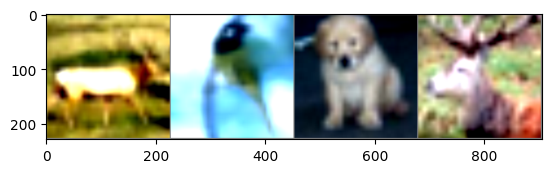

 Deer  Bird   Dog  Deer


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
AlexNet_Model = Alexnet(3, 10)


In [23]:
AlexNet_Model.eval()

Alexnet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, d

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
print(device)

cuda:0


In [27]:
torch.manual_seed(123)
if device =='cuda':
    torch.cuda.manual_seed_all(123)

In [28]:
AlexNet_Model.to(device)

Alexnet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, d

In [29]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_Model.parameters(), lr=0.001, momentum=0.9)

In [30]:
import time

In [ ]:
for epoch in range(7):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet')

In [32]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 77.58 %


In [33]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_Model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Airplane : 74 %
Accuracy of   Car : 93 %
Accuracy of  Bird : 62 %
Accuracy of   Cat : 63 %
Accuracy of  Deer : 77 %
Accuracy of   Dog : 76 %
Accuracy of  Frog : 83 %
Accuracy of Horse : 76 %
Accuracy of  Ship : 89 %
Accuracy of Truck : 79 %


In [34]:
#Verifying average accuracy of the network
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  77.58
